In [2]:
import pickle

In [3]:
import torch.nn as nn

class LinearProbe(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

class AdaptiveSoftmaxProbe(nn.Module):
    def __init__(self, input_dim, n_classes):
        super().__init__()
        cutoffs = [min(1000, n_classes - 1)]
        if n_classes > 10000:
            cutoffs.append(min(10000, n_classes - 2))
        self.adaptive_softmax = nn.AdaptiveLogSoftmaxWithLoss(
            in_features=input_dim,
            n_classes=n_classes,
            cutoffs=cutoffs,
            div_value=4.0
        )

    def forward(self, x, target=None):
        if target is not None:
            return self.adaptive_softmax(x, target)
        else:
            return self.adaptive_softmax.log_prob(x)

In [4]:
PROBE_DIR = 'trained_models/20250329_183025'

with open('trained_models/20250329_183025/dep_model.pkl', 'rb') as file:
    dep_model = pickle.load(file)

with open('trained_models/20250329_233721/pos_model.pkl', 'rb') as file:
    pos_model = pickle.load(file)


In [5]:
with open('trained_models/20250331_022918//word_model.pkl', 'rb') as file:
    word_model = pickle.load(file)

In [6]:
with open('./dataset.pkl', 'rb') as f:
    df = pickle.load(f)

In [7]:
df

,word,embedding,pos,dep,position,sentence_id,sentence
0,The,"[tensor(-0.2899), tensor(0.2611), tensor(-0.30...",DET,det,0,0,The Fulton County Grand Jury said Friday an in...
1,Fulton,"[tensor(-0.1788), tensor(0.6752), tensor(-0.56...",PROPN,compound,1,0,The Fulton County Grand Jury said Friday an in...
2,County,"[tensor(-0.2251), tensor(-0.0033), tensor(-0.2...",PROPN,compound,2,0,The Fulton County Grand Jury said Friday an in...
3,Grand,"[tensor(-0.5069), tensor(0.2878), tensor(0.179...",ADJ,amod,3,0,The Fulton County Grand Jury said Friday an in...
4,Jury,"[tensor(0.2416), tensor(0.0862), tensor(0.1484...",PROPN,nsubj,4,0,The Fulton County Grand Jury said Friday an in...
...,...,...,...,...,...,...,...
435043,outside,"[tensor(0.6717), tensor(0.2565), tensor(0.3406...",ADJ,amod,26,19999,"Of course, most toilets are Eastern style -- a..."
435044,toilets,"[tensor(0.5431), tensor(-0.2458), tensor(-0.18...",NOUN,conj,27,19999,"Of course, most toilets are Eastern style -- a..."
435045,--,"[tensor(0.3646), tensor(0.1068), tensor(0.0683...",PUNCT,punct,28,19999,"Of course, most toilets are Eastern style -- a..."
435046,inside,"[tensor(0.6022), tensor(-0.3015), tensor(-0.66...",ADV,advmod,29,19999,"Of course, most toilets are Eastern style -- a..."


In [255]:
from sklearn.preprocessing import LabelEncoder

le_pos = LabelEncoder().fit(df["pos"])
le_dep = LabelEncoder().fit(df["dep"])
le_word = LabelEncoder().fit(df["word"].str.lower())

In [7]:
le_pos.classes_

array(['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM',
       'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X'],
      dtype=object)

## Perform SVD on POS

In [23]:
import torch
import numpy as np

weights_matrix = pos_model.linear.weight.detach().cpu().numpy()  # shape: (n_classes, d_embeddings)

U, sigma, VT = np.linalg.svd(weights_matrix, full_matrices=False)

print("U matrix shape:", U.shape)
print("Sigma (singular values) shape:", sigma.shape)
print("VT matrix shape:", VT.shape)

U matrix shape: (17, 17)
Sigma (singular values) shape: (17,)
VT matrix shape: (17, 384)


## Cosine simularity of the singular vectors with each of our probe directions

## Rough thoughts here are that:
1. First singular vector strongly related to punctuation
2. The second is captures pronouns and determiners
3. The third captures verb-related POS (both verbs and auxiliary verbs which are separate tags but related)
4. Adpositions/adverbs but opposed to pronouns
5. Also determiners-related

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

for singular_vector_pos in range(5):
    print(f'For singular vector at position {singular_vector_pos}')
    print(f'Corresponding singular value: {sigma[singular_vector_pos]:.2f}')
    results = []
    for i, pos_class in enumerate(le_pos.classes_):
        similarity = cosine_similarity(VT[singular_vector_pos].reshape(1,-1), weights_matrix[i].reshape(1,-1))
        results.append((pos_class, similarity))
    results = sorted(results, key=lambda x: abs(x[1]), reverse=True)
    print(f'Top 10 cosine similarities and corresponding probe direction')
    for pos, sim in results[:10]:
        print(f'{pos}: {sim[0][0]:.2f}')
    print('--------')

For singular vector at position 0
Corresponding singular value: 25.99
Top 10 cosine similarities and corresponding probe direction
PUNCT: 0.76
NOUN: -0.74
PART: 0.54
SCONJ: 0.54
ADP: 0.52
PROPN: -0.50
ADJ: -0.48
CCONJ: 0.48
SYM: 0.46
VERB: -0.39
--------
For singular vector at position 1
Corresponding singular value: 18.92
Top 10 cosine similarities and corresponding probe direction
PUNCT: -0.60
PRON: 0.43
SCONJ: 0.43
DET: 0.39
CCONJ: 0.39
ADP: 0.33
NOUN: -0.27
ADV: 0.26
VERB: -0.25
PROPN: -0.20
--------
For singular vector at position 2
Corresponding singular value: 17.26
Top 10 cosine similarities and corresponding probe direction
AUX: 0.66
CCONJ: -0.49
VERB: 0.47
PROPN: -0.44
PART: 0.41
NOUN: -0.33
ADP: 0.25
PRON: -0.20
PUNCT: -0.18
ADJ: 0.15
--------
For singular vector at position 3
Corresponding singular value: 16.55
Top 10 cosine similarities and corresponding probe direction
ADP: 0.62
PRON: -0.57
DET: -0.42
AUX: -0.39
SCONJ: 0.37
ADV: 0.35
NUM: -0.23
ADJ: 0.17
CCONJ: -0.16
PART

## Can we reconstruct the weights matrix using the top singular values?

In [10]:
reconstructed_weights = np.dot(U, np.dot(np.diag(sigma), VT))
print(np.allclose(weights_matrix, reconstructed_weights, rtol=1e-4, atol=1e-4))

k = 10
U_k = U[:, :k]
sigma_k = np.diag(sigma[:k])
VT_k = VT[:k, :]

reconstructed_weights_k = np.dot(U_k, np.dot(sigma_k, VT_k))
print(np.allclose(weights_matrix, reconstructed_weights_k, rtol=1e-3, atol=1e-3))

squared_diff = (weights_matrix - reconstructed_weights_k) ** 2
mean_squared_diff = np.mean(squared_diff, axis=None)
print(f'Average mean squared diff by position: {mean_squared_diff:.2f}')

True
False
Average mean squared diff by position: 0.06


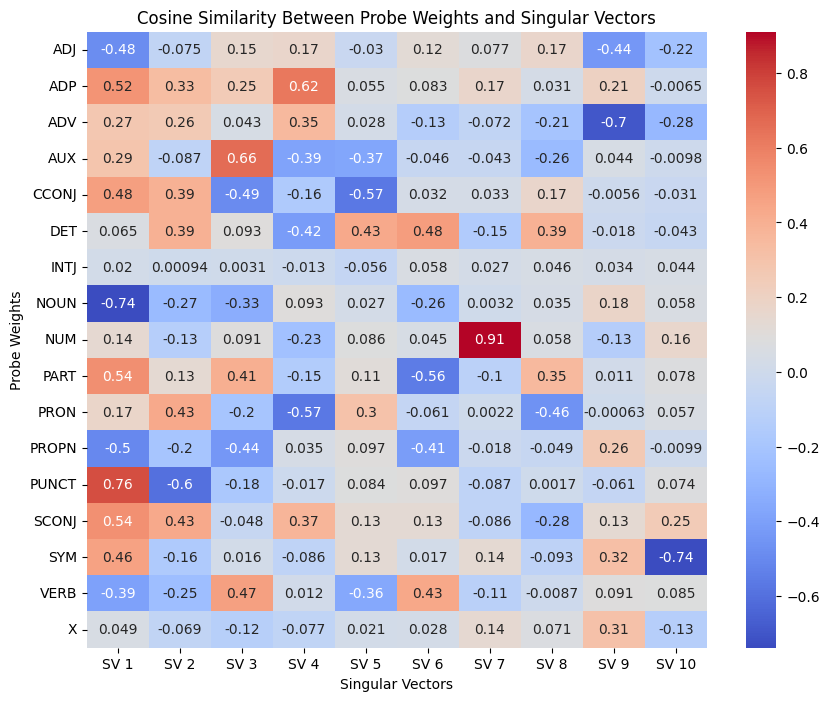

In [11]:
## Cosine similarity heatmap

from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

cos_sim = cosine_similarity(weights_matrix, VT[:10, :])

plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim, annot=True, cmap="coolwarm", xticklabels=[f"SV {i+1}" for i in range(10)], yticklabels=le_pos.classes_)
plt.title("Cosine Similarity Between Probe Weights and Singular Vectors")
plt.xlabel("Singular Vectors")
plt.ylabel("Probe Weights")
plt.show()

## Try PCA? expecting similar-ish results

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(weights_matrix)
VT = pca.components_

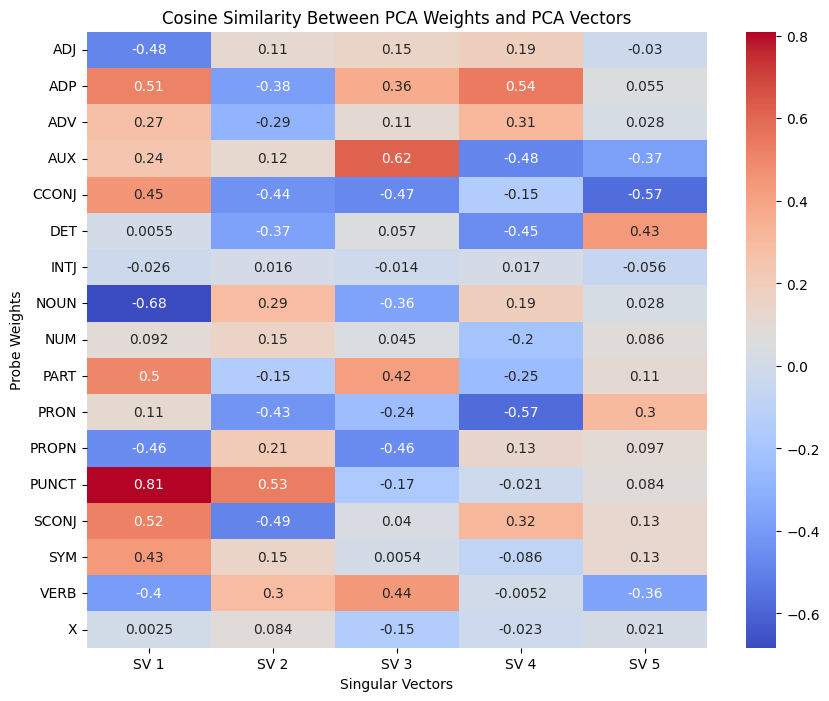

In [30]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

cos_sim = cosine_similarity(weights_matrix, VT)

plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim, annot=True, cmap="coolwarm", xticklabels=[f"SV {i+1}" for i in range(5)], yticklabels=le_pos.classes_)
plt.title("Cosine Similarity Between PCA Weights and PCA Vectors")
plt.xlabel("Singular Vectors")
plt.ylabel("Probe Weights")
plt.show()

## Let's try to prove causality here by finding neurons from the original model with directions correlated with the probe weights
#### This helps show that the representations not only exist but the model uses them

In [31]:
from transformers import AutoTokenizer, AutoModel

# Load tokenizer and model
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

In [115]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

model.eval()

import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def find_aligned_neurons(model, probe_directions, layer_to_analyze, top_k=10):
    layer = model.encoder.layer[layer_to_analyze]
    neuron_weights = layer.intermediate.dense.weight.detach().cpu().numpy()

    aligned_neurons = {}
    for i, probe_direction in enumerate(probe_directions):
        similarities = cosine_similarity(neuron_weights, probe_direction.reshape(1, -1)).flatten()
        top_neuron_indices = np.argsort(similarities)[-top_k:]
        top_neuron_similarities = similarities[top_neuron_indices]
        aligned_neurons[f"probe_direction_{i}"] = {
            "indices": top_neuron_indices.tolist(),
            "similarities": top_neuron_similarities.tolist()
        }
    return aligned_neurons

# def project_activations(model, input_data, aligned_neurons, probe_directions, layer_to_analyze):
#     model.eval()
#     projected_activations = {}

#     with torch.no_grad():
#         for input_batch in input_data:
#             outputs = model(input_batch, output_hidden_states=True)
#             hidden_states = outputs.hidden_states[layer_to_analyze + 1].cpu().numpy()

#             for i, probe_direction in enumerate(probe_directions):
#                 neuron_indices = aligned_neurons[f"probe_direction_{i}"]["indices"]
#                 for neuron_index in neuron_indices:
#                     neuron_index = int(neuron_index)
#                     for batch_index in range(hidden_states.shape[0]):
#                         for seq_index in range(hidden_states.shape[1]):
#                             neuron_activation = hidden_states[batch_index, seq_index, neuron_index]
#                             projected = np.dot(neuron_activation, probe_direction)
#                             if f"probe_direction_{i}" not in projected_activations:
#                                 projected_activations[f"probe_direction_{i}"] = []
#                             projected_activations[f"probe_direction_{i}"].append(projected)

#     return projected_activations



unique_sentences = df['sentence'].unique()[:100]
encoded_inputs = tokenizer(
    unique_sentences.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)
input_data = encoded_inputs['input_ids'].unsqueeze(0)
aligned_neurons = find_aligned_neurons(model, weights_matrix, 2)
# projected_activations = project_activations(model, input_data, aligned_neurons, weights_matrix, 2)

In [116]:
num_layers = len(model.encoder.layer)

for layer_index in [2]:
    aligned_neurons_results = find_aligned_neurons(model, weights_matrix, layer_index)
    print(f"\nResults for Layer {layer_index}:")
    for direction, neuron_info in aligned_neurons_results.items():
        top_similarity = neuron_info["similarities"][0] # get the top similarity.
        print(f"  {direction}: Top Similarity = {top_similarity:.2f}")


Results for Layer 2:
  probe_direction_0: Top Similarity = 0.14
  probe_direction_1: Top Similarity = 0.15
  probe_direction_2: Top Similarity = 0.14
  probe_direction_3: Top Similarity = 0.15
  probe_direction_4: Top Similarity = 0.17
  probe_direction_5: Top Similarity = 0.15
  probe_direction_6: Top Similarity = 0.15
  probe_direction_7: Top Similarity = 0.13
  probe_direction_8: Top Similarity = 0.13
  probe_direction_9: Top Similarity = 0.17
  probe_direction_10: Top Similarity = 0.16
  probe_direction_11: Top Similarity = 0.14
  probe_direction_12: Top Similarity = 0.17
  probe_direction_13: Top Similarity = 0.17
  probe_direction_14: Top Similarity = 0.13
  probe_direction_15: Top Similarity = 0.14
  probe_direction_16: Top Similarity = 0.16


## Similar to above but for DEP

## The patterns here are:
1. Seems to capture elements related to sentence structure (punctuation, conjunctions, etc.)
2. 

In [12]:
import torch
import numpy as np

weights_matrix = dep_model.linear.weight.detach().cpu().numpy()  # shape: (n_classes, d_embeddings)

U, sigma, VT = np.linalg.svd(weights_matrix, full_matrices=False)

print("U matrix shape:", U.shape)
print("Sigma (singular values) shape:", sigma.shape)
print("VT matrix shape:", VT.shape)

for singular_vector_pos in range(5):
    print(f'For singular vector at position {singular_vector_pos}')
    print(f'Corresponding singular value: {sigma[singular_vector_pos]:.2f}')
    results = []
    for i, pos_class in enumerate(le_dep.classes_):
        similarity = cosine_similarity(VT[singular_vector_pos].reshape(1,-1), weights_matrix[i].reshape(1,-1))
        results.append((pos_class, similarity))
    results = sorted(results, key=lambda x: abs(x[1]), reverse=True)
    print(f'Top 10 cosine similarities and corresponding probe direction')
    for pos, sim in results[:10]:
        print(f'{pos}: {sim[0][0]:.2f}')
    print('--------')

U matrix shape: (49, 49)
Sigma (singular values) shape: (49,)
VT matrix shape: (49, 384)
For singular vector at position 0
Corresponding singular value: 32.04
Top 10 cosine similarities and corresponding probe direction
punct: 0.73
case: 0.73
mark: 0.68
fixed: 0.67
cc: 0.59
nmod: -0.58
obl: -0.56
obj: -0.55
cop: 0.52
advmod: 0.49
--------
For singular vector at position 1
Corresponding singular value: 19.51
Top 10 cosine similarities and corresponding probe direction
acl:relcl: -0.65
advcl: -0.64
nsubj:pass: 0.59
nsubj: 0.58
acl: -0.55
cop: -0.53
ccomp: -0.45
aux:pass: -0.45
obj: 0.44
aux: -0.42
--------
For singular vector at position 2
Corresponding singular value: 17.98
Top 10 cosine similarities and corresponding probe direction
punct: -0.61
ccomp: -0.35
root: -0.34
mark: 0.33
cc: 0.32
parataxis: -0.30
fixed: 0.26
det: 0.26
amod: 0.25
xcomp: -0.24
--------
For singular vector at position 3
Corresponding singular value: 15.58
Top 10 cosine similarities and corresponding probe direct

## Correlation heatmaps and t-SNE on DEP.

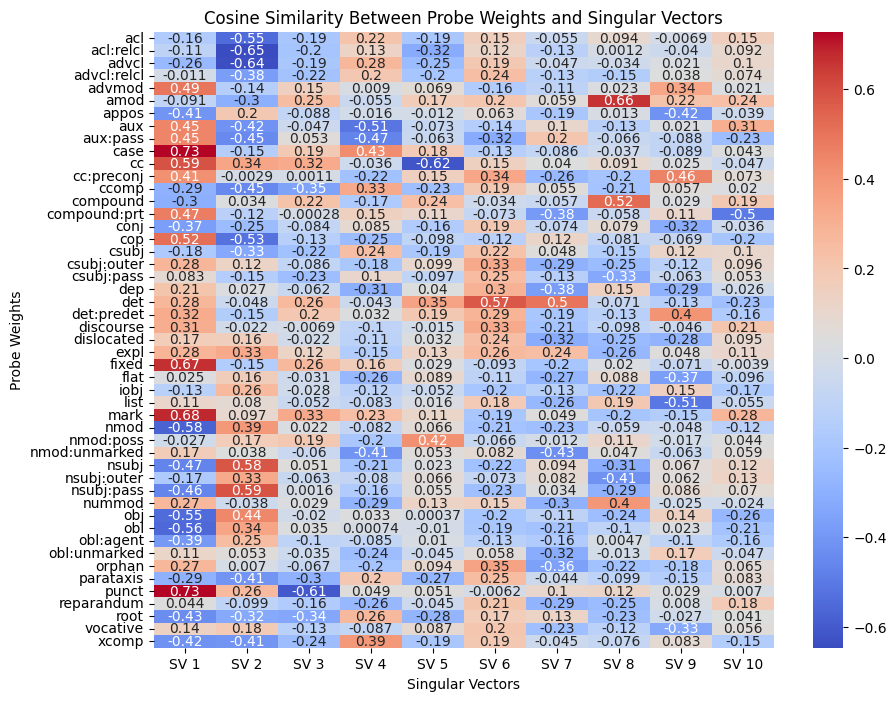

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

cos_sim = cosine_similarity(weights_matrix, VT[:10, :])

plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim, annot=True, cmap="coolwarm", xticklabels=[f"SV {i+1}" for i in range(10)], yticklabels=le_dep.classes_)
plt.title("Cosine Similarity Between Probe Weights and Singular Vectors")
plt.xlabel("Singular Vectors")
plt.ylabel("Probe Weights")
plt.show()

#### Realized that t-SNE actually will not work since VT is supposed to operate on a rotated/scaled version of the original matrix

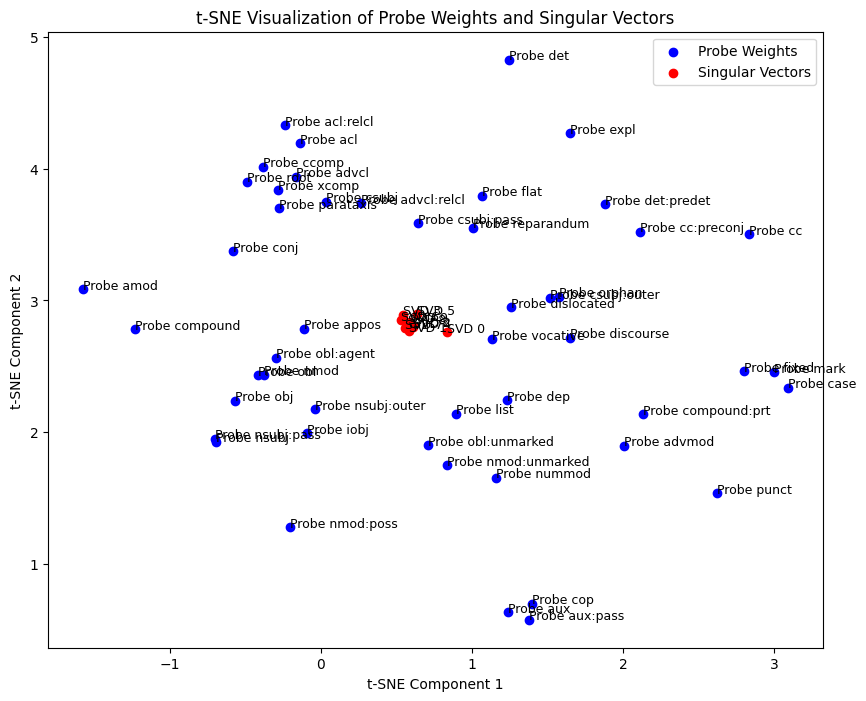

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

k = 10  # Top 10 singular vectors
top_k_singular_vectors = VT[:k, :]  # shape (k x embedding_size)

combined_matrix = np.vstack([weights_matrix, top_k_singular_vectors])

labels = ['Probe ' + class_name for class_name in le_dep.classes_] + ['SVD ' + str(i) for i in range(k)]

tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(combined_matrix)

plt.figure(figsize=(10, 8))

plt.scatter(reduced_data[:weights_matrix.shape[0], 0], reduced_data[:weights_matrix.shape[0], 1], label="Probe Weights", color='blue')
plt.scatter(reduced_data[weights_matrix.shape[0]:, 0], reduced_data[weights_matrix.shape[0]:, 1], label="Singular Vectors", color='red')

for i, label in enumerate(labels):
    plt.text(reduced_data[i, 0], reduced_data[i, 1], label, fontsize=9)

plt.title('t-SNE Visualization of Probe Weights and Singular Vectors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.legend()

plt.show()

## Check reconstruction

In [8]:
sample_df = df[:10000]

In [9]:
sample_df.head()

,word,embedding,pos,dep,position,sentence_id,sentence
0,The,"[tensor(-0.2899), tensor(0.2611), tensor(-0.30...",DET,det,0,0,The Fulton County Grand Jury said Friday an in...
1,Fulton,"[tensor(-0.1788), tensor(0.6752), tensor(-0.56...",PROPN,compound,1,0,The Fulton County Grand Jury said Friday an in...
2,County,"[tensor(-0.2251), tensor(-0.0033), tensor(-0.2...",PROPN,compound,2,0,The Fulton County Grand Jury said Friday an in...
3,Grand,"[tensor(-0.5069), tensor(0.2878), tensor(0.179...",ADJ,amod,3,0,The Fulton County Grand Jury said Friday an in...
4,Jury,"[tensor(0.2416), tensor(0.0862), tensor(0.1484...",PROPN,nsubj,4,0,The Fulton County Grand Jury said Friday an in...


In [253]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd

model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

In [303]:
import pandas as pd
import torch

pos_weights = pos_model.linear.weight.detach().cpu().numpy()
dep_weights = dep_model.linear.weight.detach().cpu().numpy()

def get_probe_weights_for_word(word, tokenizer):
    word_tokens = tokenizer.encode(word)
    
    if len(word_tokens) == 0:
        raise ValueError(f"Word '{word}' not found in the tokenizer's vocabulary.")
    
    word_idx = list(le_word.classes_).index(word)
    probe_weights = word_model.linear.weight[word_idx].detach().cpu().numpy()
    return probe_weights / len(word_tokens)


def compute_sentence_embeddings(df, tokenizer):
    sentence_embeddings = []
    
    for sentence_id, group in df.groupby('sentence_id'):
        weighted_sum = torch.zeros(384)
        total_num_tokens = 0

        for _, row in group.iterrows():
            word = row['word'].lower()
            total_num_tokens += 1
            probe_weight = get_probe_weights_for_word(word, tokenizer)
            weighted_sum += probe_weight

        # get POS
        pos = row['pos']
        pos_idx = list(le_pos.classes_).index(pos)
        pos_probe_weight = pos_weights[pos_idx]

        # get DEP
        dep = row['dep']
        dep_idx = list(le_dep.classes_).index(dep)
        dep_probe_weight = dep_weights[dep_idx]

        full_probe_embedding = (weighted_sum.numpy() / total_num_tokens) + pos_probe_weight + dep_probe_weight
     
        sentence_embeddings.append({
            'sentence_id': sentence_id,
            'sentence': group['sentence'].iloc[0],
            'probe_embedding': full_probe_embedding
        })
    
    return pd.DataFrame(sentence_embeddings)

summed_embeddings = compute_sentence_embeddings(sample_df, tokenizer)
summed_embeddings = summed_embeddings.drop_duplicates('sentence')

In [304]:
all_sentences = summed_embeddings['sentence'].values.tolist()
inputs = tokenizer(all_sentences, padding=True, truncation=True, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state

input_ids = inputs['input_ids']
mask = (input_ids != tokenizer.pad_token_id) & (input_ids != tokenizer.cls_token_id) & (input_ids != tokenizer.sep_token_id)
masked_embeddings = embeddings[mask]
sentence_embeddings = torch.mean(embeddings, dim=1)

In [305]:
summed_embeddings['sentence_embedding'] = [sentence_embeddings[i].numpy() for i in range(sentence_embeddings.shape[0])]

In [306]:
summed_embeddings.head()

,sentence_id,sentence,probe_embedding,sentence_embedding
0,0,The Fulton County Grand Jury said Friday an in...,"[-0.6884442, -2.7505603, 0.19381449, -0.769655...","[-0.199473, 0.11403245, -0.046557795, 0.034434..."
1,1,The jury further said in term-end presentments...,"[-0.704688, -2.783004, 0.2750517, -0.74582595,...","[-0.28783968, 0.21571113, 0.24254103, -0.01256..."
2,2,The September-October term jury had been charg...,"[-0.65804935, -2.7742877, 0.25500733, -0.80355...","[-0.086236216, -0.009242435, -0.0013334784, -0..."
3,3,Only a relative handful of such reports was r...,"[-0.69521594, -2.844677, 0.27663457, -0.760392...","[0.3950015, -0.072025806, 0.24024844, 0.150863..."
4,4,The jury said it did find that many of Georgia...,"[-0.633307, -2.7434435, 0.24641067, -0.7174921...","[-0.2643653, -0.16068602, 0.2723819, 0.1521909..."


In [307]:
from sklearn.metrics import r2_score

sentence_embeddings_np = np.array([embedding for embedding in summed_embeddings['sentence_embedding']])
probe_embeddings_np = np.array([embedding for embedding in summed_embeddings['probe_embedding']])

r2 = r2_score(sentence_embeddings_np, probe_embeddings_np)
r2

-9555052331008.0

In [309]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = np.diag(cosine_similarity(sentence_embeddings_np, probe_embeddings_np))

In [310]:
cos_sim.mean()

0.0056039025

In [311]:
squared_diff_elementwise = (sentence_embeddings_np - probe_embeddings_np) ** 2
mse_rowwise = np.mean(squared_diff_elementwise, axis=1)
average_mse = np.mean(mse_rowwise)
average_mse

4.5964723

In [261]:
print(sentence_embeddings_np.shape)
print(probe_embeddings_np.shape)

(430, 384)
(430, 384)


In [235]:
summed_embeddings['sentence'][0]

"The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced  no evidence  that any irregularities took place."

In [236]:
tokens = tokenizer.encode(summed_embeddings['sentence'][0])

In [248]:
for token in tokens:
    text = tokenizer.decode(token)
    print (token, tokenizer.decode(token))
    try:
        print (list(le_word.classes_).index(text))
    except:
        print (f'{text} is not in model')

101 [CLS]
[CLS] is not in model
1996 the
29278
17049 fulton
fulton is not in model
2221 county
14808
2882 grand
18733
6467 jury
20710
2056 said
26567
5958 friday
friday is not in model
2019 an
11174
4812 investigation
20483
1997 of
22995
5865 atlanta
atlanta is not in model
1005 '
5
1055 s
26528
3522 recent
25502
3078 primary
24671
2602 election
16609
2550 produced
24761
2053 no
22692
3350 evidence
17127
2008 that
29273
2151 any
11325
28868 irregularities
20535
2165 took
29576
2173 place
24097
1012 .
54
102 [SEP]
[SEP] is not in model


In [302]:
dep_weights[0]

array([-5.10794111e-02, -1.05260420e+00,  3.02997548e-02,  5.14458001e-01,
        1.68315724e-01, -7.83705711e-02,  2.88460195e-01, -1.10963151e-01,
        3.94270480e-01, -1.24387909e-02, -8.53155032e-02, -5.23736589e-02,
        2.39905015e-01,  1.36254340e-01,  1.85852721e-01,  1.90705508e-01,
        4.28533480e-02, -1.59302011e-01, -7.84705222e-01, -9.71448887e-03,
        4.40812677e-01,  5.93485296e-01,  3.09456617e-01,  3.11705410e-01,
       -3.99911135e-01,  2.20015824e-01, -2.71515399e-02, -5.22086799e-01,
        6.14074804e-02,  3.25346351e-01,  3.53241742e-01, -2.04333708e-01,
        2.10375383e-01, -2.85883456e-01, -8.71205389e-01,  1.27616554e-01,
       -3.09237629e-01,  3.64150442e-02, -8.83819237e-02,  7.27842510e-01,
        9.53115746e-02,  5.73541895e-02,  1.58274919e-01, -7.74498517e-03,
        1.49379775e-01, -1.83481514e-01, -3.37135583e-01,  1.32566616e-01,
       -7.39452481e-01,  3.08922112e-01,  1.55591890e-01, -6.99843243e-02,
       -9.55637634e-01, -